# Lab 2 - Arturo Avalos

Getting the data:

In [1]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

In [2]:
from sklearn import datasets
data = datasets.load_iris(as_frame=True)
data = data.frame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [3]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


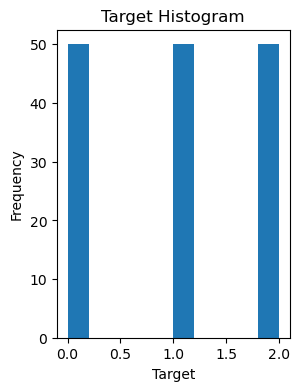

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,4))

plt.hist(data['target'])
plt.title('Target Histogram')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()


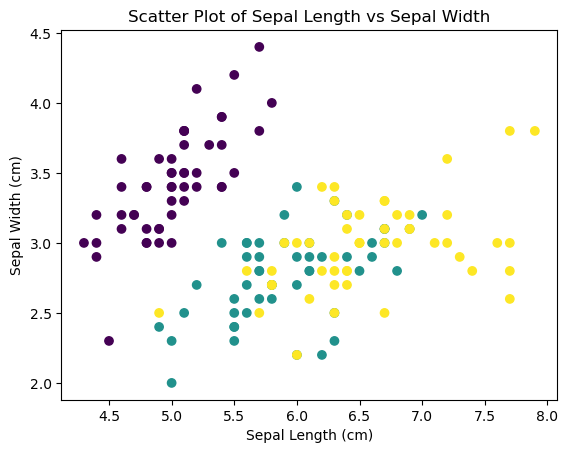

In [5]:
plt.scatter(data['sepal length (cm)'], data['sepal width (cm)'], c=data['target'])
plt.title('Scatter Plot of Sepal Length vs Sepal Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()

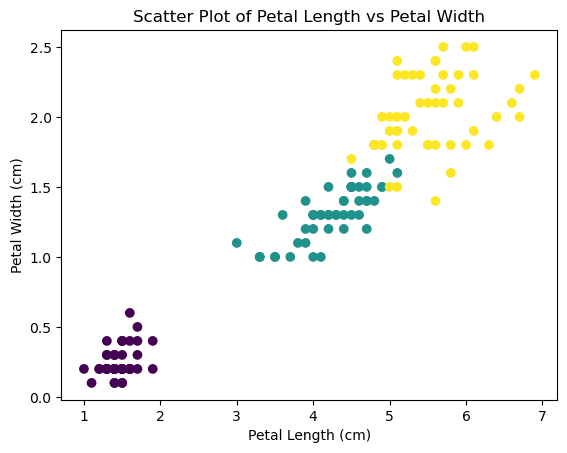

In [6]:
plt.scatter(data['petal length (cm)'], data['petal width (cm)'], c=data['target'])
plt.title('Scatter Plot of Petal Length vs Petal Width')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.show()


In [7]:
y = data['target']
X = data.drop('target', axis=1)

In [8]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Training

In [9]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('iris-classification')

<Experiment: artifact_location='/Users/arturoavalos/Documents/MSDS/4mod/mlops/mlruns/4', creation_time=1742859512056, experiment_id='4', last_update_time=1742859512056, lifecycle_stage='active', name='iris-classification', tags={}>

### Descision Tree 

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']

for depth in max_depths:
    for criterion in criterions:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "decision-tree", "Train Data": "80%"})
            
            mlflow.log_params({'max_depth': depth, 'criterion': criterion})
            
            dt = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### Knn

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_neighbors_values = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']

for n_neighbors in n_neighbors_values:
    for weights in weights_options:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "knn", "Train Data": "80%"})
            
            mlflow.log_params({'n_neighbors': n_neighbors, 'weights': weights})
            
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']
n_estimators = [50, 100, 200]

for depth in max_depths:
    for criterion in criterions:
        for n_estimator in n_estimators:
            with mlflow.start_run():
                mlflow.set_tags({"Model": "random-forest", "Train Data": "80%"})
                
                mlflow.log_params({
                    'max_depth': depth, 
                    'criterion': criterion,
                    'n_estimators': n_estimator
                })
                
                rf = RandomForestClassifier(
                    max_depth=depth, 
                    criterion=criterion,
                    n_estimators=n_estimator,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                
                mlflow.log_metric('accuracy', acc)
            mlflow.end_run()

### Feature selection

Feature Importances:
             Feature  Importance
2  petal length (cm)    0.466330
3   petal width (cm)    0.407388
0  sepal length (cm)    0.096623
1   sepal width (cm)    0.029659


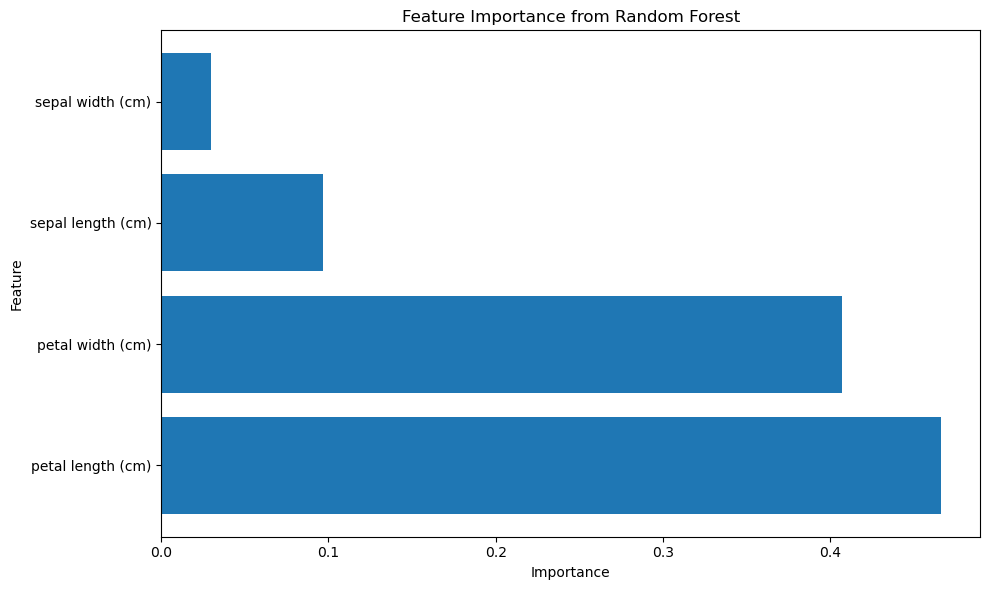

In [16]:
# Get feature importance from the best Random Forest model
#Actually all randoom forest model tested equally
rf_best = RandomForestClassifier(
    max_depth=10,  # Using a reasonable depth
    criterion='entropy',
    n_estimators=200,
    random_state=42
)
rf_best.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_best.feature_importances_

# Create a DataFrame to display feature importances
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

Checks out given our graph, let's now only use these two features.

In [18]:
red_X = X.drop(['sepal length (cm)','sepal width (cm)'], axis=1)


In [19]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(red_X, y, test_size=0.2, shuffle=True)

### Decison Tree v2

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']

for depth in max_depths:
    for criterion in criterions:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "decision-tree-v2", "Train Data": "80%"})
            
            mlflow.log_params({'max_depth': depth, 'criterion': criterion})
            
            dt = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### KNN v2

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_neighbors_values = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']

for n_neighbors in n_neighbors_values:
    for weights in weights_options:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "knn-v2", "Train Data": "80%"})
            
            mlflow.log_params({'n_neighbors': n_neighbors, 'weights': weights})
            
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### Random Forest v2

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']
n_estimators = [50, 100, 200]

for depth in max_depths:
    for criterion in criterions:
        for n_estimator in n_estimators:
            with mlflow.start_run():
                mlflow.set_tags({"Model": "random-forest-v2", "Train Data": "80%"})
                
                mlflow.log_params({
                    'max_depth': depth, 
                    'criterion': criterion,
                    'n_estimators': n_estimator
                })
                
                rf = RandomForestClassifier(
                    max_depth=depth, 
                    criterion=criterion,
                    n_estimators=n_estimator,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                
                mlflow.log_metric('accuracy', acc)
            mlflow.end_run()

### Staging the best model

In [24]:
# Query MLflow to find the best model based on accuracy
import mlflow
from mlflow.entities import ViewType

# Get all runs from the experiment
experiment = mlflow.get_experiment_by_name("iris-classification")
runs = mlflow.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.accuracy DESC"]
)

# Get the best run (first row in the sorted dataframe)
best_run = runs.iloc[0]
best_run_id = best_run.run_id
best_accuracy = best_run["metrics.accuracy"]
best_model_params = {
    'max_depth': best_run["params.max_depth"],
    'criterion': best_run["params.criterion"],
    'n_estimators': best_run["params.n_estimators"]
}

print(f"Best model run ID: {best_run_id}")
print(f"Best model accuracy: {best_accuracy:.4f}")
print(f"Best model parameters: {best_model_params}")

# Register the best model in the MLflow Model Registry
model_uri = f"runs:/{best_run_id}/model"
model_name = "iris_classifier"

# Register the model
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

# Transition the model to staging
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_details.version,
    stage="Staging"
)

print(f"Model {model_name} version {model_details.version} transitioned to Staging")


Best model run ID: ca8000ef00014850b73d5bfe6e873dea
Best model accuracy: 1.0000
Best model parameters: {'max_depth': 'None', 'criterion': 'entropy', 'n_estimators': '200'}
Model iris_classifier version 1 transitioned to Staging


Successfully registered model 'iris_classifier'.
Created version '1' of model 'iris_classifier'.
/var/folders/qb/x618gqzx23qfnqfcr7h_v1_r0000gn/T/ipykernel_83338/1485909287.py:37: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


### Running it on the test set

In [32]:
# Recreate the model with the best parameters
best_model = RandomForestClassifier(
    max_depth=None if best_model_params['max_depth'] == 'None' else int(best_model_params['max_depth']), 
    criterion=best_model_params['criterion'],
    n_estimators=int(best_model_params['n_estimators'])
)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Log the test metrics to MLflow
with mlflow.start_run(run_id=best_run_id):
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    # Log classification report
    from sklearn.metrics import classification_report
    # Get unique target names from the dataset
    target_names = [f"Class {i}" for i in sorted(y.unique())]
    report = classification_report(y_test, y_pred, target_names=target_names)
    mlflow.log_text(report, "test_classification_report.txt")
    print("\nClassification Report:")
    print(report)


Test set accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        12
     Class 1       1.00      1.00      1.00         8
     Class 2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Logging best models information

In [36]:
top_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.max_depth,params.criterion,params.n_estimators,params.n_neighbors,params.weights,tags.Model,tags.mlflow.source.name,tags.mlflow.user,tags.Train Data,tags.mlflow.runName,tags.mlflow.source.type
0,ca8000ef00014850b73d5bfe6e873dea,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:25.020000+00:00,2025-03-25 00:17:25.103000+00:00,1.0,None,entropy,200,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,orderly-steed-643,LOCAL
1,0b0fdd87c62d4f3b915d14d486152877,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:24.947000+00:00,2025-03-25 00:17:24.973000+00:00,1.0,None,entropy,50,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,respected-whale-174,LOCAL
2,04f690032ab840b6b260eaa47e8dc065,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:24.863000+00:00,2025-03-25 00:17:24.945000+00:00,1.0,None,gini,200,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,learned-pug-207,LOCAL


In [38]:
# Get the top 3 runs from the DataFrame
top_runs = runs.iloc[:3]

for i, (_, run_row) in enumerate(top_runs.iterrows(), 1):
    run_id = run_row['run_id']
    
    print(f"\nBest Model #{i} (Run ID: {run_id}):")
    # Fix the formatting error by checking if the value is a string or number
    train_accuracy = run_row.get('metrics.train_accuracy', 'N/A')
    if isinstance(train_accuracy, (int, float)):
        print(f"Training Accuracy: {train_accuracy:.4f}")
    else:
        print(f"Training Accuracy: {train_accuracy}")
    
    # Fix the test accuracy display similarly
    test_accuracy = run_row.get('metrics.test_accuracy', 'N/A')
    if 'metrics.test_accuracy' in run_row:
        if isinstance(test_accuracy, (int, float)):
            print(f"Test Accuracy: {test_accuracy:.4f}")
        else:
            print(f"Test Accuracy: {test_accuracy}")
    else:
        print("Test Accuracy: Not yet evaluated")
    
    print("\nHyperparameters:")
    # Extract parameters from the DataFrame row
    param_columns = [col for col in run_row.index if col.startswith('params.')]
    for param_col in param_columns:
        param_name = param_col.replace('params.', '')
        param_value = run_row[param_col]
        if param_value is not None:  # Only print non-None parameters
            print(f"  {param_name}: {param_value}")
    
    # Log dataset information
    try:
        with mlflow.start_run(run_id=run_id, nested=True):
            mlflow.log_dict({
                "dataset_info": {
                    "training_set_shape": X_train.shape,
                    "test_set_shape": X_test.shape,
                    "training_samples": len(X_train),
                    "test_samples": len(X_test),
                    "features": list(X.columns),
                    "target_classes": sorted(y.unique().tolist())
                }
            }, "dataset_info.json")
    except Exception as e:
        print(f"Could not log dataset info for run {run_id}: {str(e)}")



Best Model #1 (Run ID: ca8000ef00014850b73d5bfe6e873dea):
Training Accuracy: N/A
Test Accuracy: Not yet evaluated

Hyperparameters:
  max_depth: None
  criterion: entropy
  n_estimators: 200

Best Model #2 (Run ID: 0b0fdd87c62d4f3b915d14d486152877):
Training Accuracy: N/A
Test Accuracy: Not yet evaluated

Hyperparameters:
  max_depth: None
  criterion: entropy
  n_estimators: 50

Best Model #3 (Run ID: 04f690032ab840b6b260eaa47e8dc065):
Training Accuracy: N/A
Test Accuracy: Not yet evaluated

Hyperparameters:
  max_depth: None
  criterion: gini
  n_estimators: 200
